# 1.Setup and load data


1.1 Install Dependencies and Setup

In [ ]:
#!pip install tensorflow  opencv-python matplotlib

In [ ]:
#!pip list

In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


1.2 Remove non png/ jp(e)g file

In [ ]:
import cv2
import imghdr


In [ ]:
data_dir ='/content/drive/MyDrive/Project_Snake/data'
img_extension = ['jpeg','jpg','png','JPG']

In [ ]:
os.listdir(data_dir)

['Crotale', 'Boomslang', 'Cobra', 'Vipère', 'Taïpan']

In [ ]:
from logging import exception

#
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in img_extension:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
             print(f'image corrupted')

1.3 Load data


In [ ]:
#build a images dataset + preprocessing ,image size and label
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 711 files belonging to 5 classes.


In [ ]:
#
data_iterator = data.as_numpy_iterator()

In [ ]:
batch =data_iterator.next()

In [ ]:
batch[1]

array([2, 4, 0, 4, 2, 0, 4, 1, 0, 4, 0, 4, 2, 1, 0, 4, 2, 0, 3, 0, 4, 3,
       4, 4, 2, 0, 4, 2, 4, 1, 4, 4], dtype=int32)

In [ ]:
# label name
class_names = data.class_names

# ddisplays the class corresponding to the index
for class_index in batch[1]:
    class_name = class_names[class_index]
    print(f"Classe {class_index}: {class_name}")


Classe 2: Crotale
Classe 4: Vipère
Classe 0: Boomslang
Classe 4: Vipère
Classe 2: Crotale
Classe 0: Boomslang
Classe 4: Vipère
Classe 1: Cobra
Classe 0: Boomslang
Classe 4: Vipère
Classe 0: Boomslang
Classe 4: Vipère
Classe 2: Crotale
Classe 1: Cobra
Classe 0: Boomslang
Classe 4: Vipère
Classe 2: Crotale
Classe 0: Boomslang
Classe 3: Taïpan
Classe 0: Boomslang
Classe 4: Vipère
Classe 3: Taïpan
Classe 4: Vipère
Classe 4: Vipère
Classe 2: Crotale
Classe 0: Boomslang
Classe 4: Vipère
Classe 2: Crotale
Classe 4: Vipère
Classe 1: Cobra
Classe 4: Vipère
Classe 4: Vipère


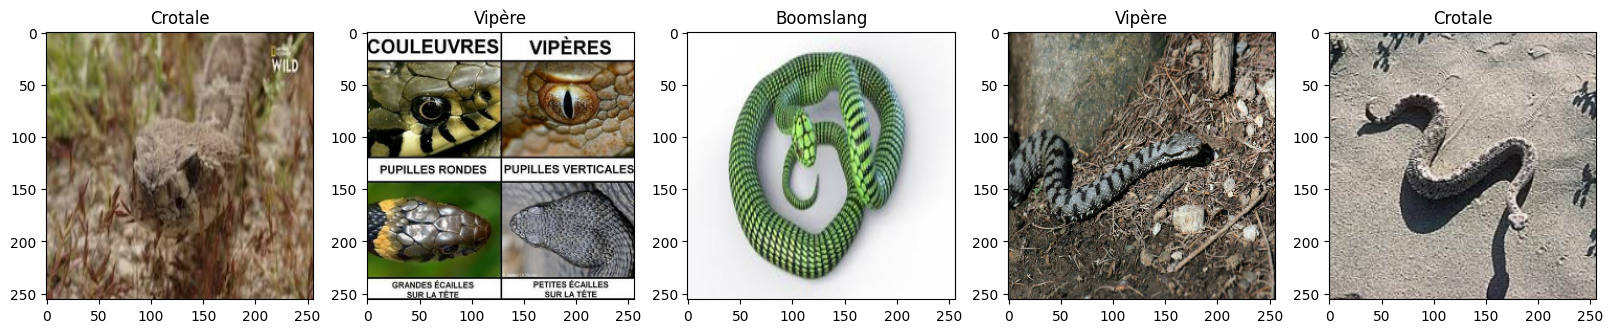

In [ ]:
fig, ax  = plt.subplots(ncols=5, figsize=(20,20))
for  idx,img in enumerate(batch[0][:5]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(class_names[batch[1][idx]])

#2.Preprocessing data

Now that we've got some data loaded the next step is to
scale the image values to between 0
and 1 instead of zero to 255.this helps
our deep learning model generalize
faster and produces better results we're
also going to split up our data into
training testing and validation
partitions to ensure that we don't
overfit let's get to it

In [ ]:
batch[0].shape

(32, 256, 256, 3)

2.1 Scale data

In [ ]:
"""we are using a data pipeline so we can loading we can transforms our images with the data pipeline"""

#scale our images between 0 and 1
scale_data = data.map(lambda x, y: (x / 255, tf.one_hot(y, depth=len(class_names))))

In [ ]:
scale_iterator = scale_data.as_numpy_iterator()

In [ ]:
batch = scale_iterator.next()

In [ ]:
batch[0].max()

1.0

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


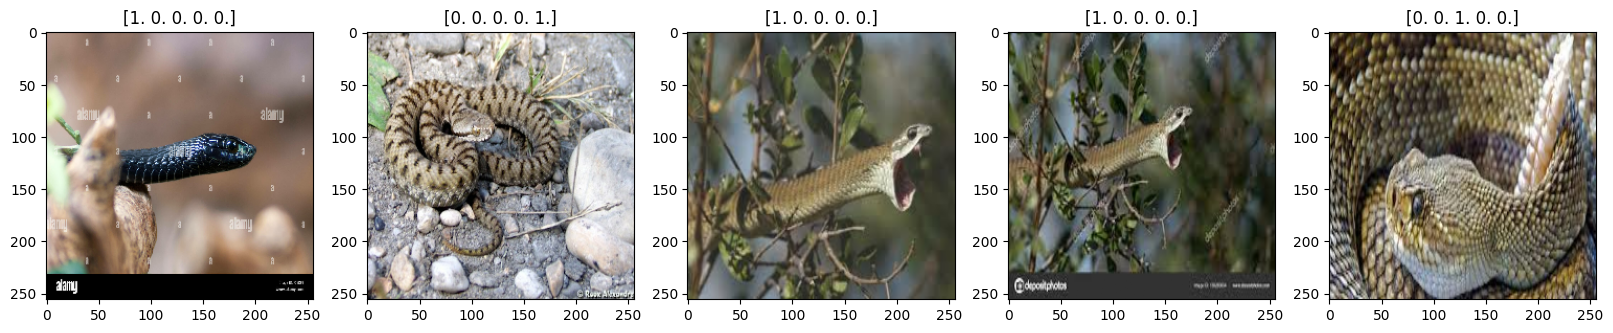

In [ ]:
fig, ax  = plt.subplots(ncols=5, figsize=(20,20))
for  idx,img in enumerate(batch[0][:5]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])


2.2 Split Data

In [ ]:
len(data)

23

In [ ]:
train_size = int(len(scale_data)*.7) # use to train our model
val_size = int(len(scale_data)*.2)+1 # use to evaluate our model
test_size = int(len(scale_data)*.1)+1 # use to test our model

In [ ]:
train_size ,val_size,test_size

(16, 5, 3)

In [ ]:
# we allocate n batch to our train ,val and test
train = scale_data.take(train_size)#16 batch
val = scale_data.skip(train_size).take(val_size)# 5 batch
test = scale_data.skip(train_size + val_size).take(test_size) # 3 batch

In [ ]:
len(train), len(val), len(test)

(16, 5, 2)

# 3.Build Deep Learning Model

3.1 build model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()

model.add(Conv2D( 64,(3,3),1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D( 32,(3,3),1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D( 16,(3,3),1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(len(class_names), activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      18464     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

3.2 Train model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
hist =model.fit(train, epochs=13, validation_data=val, callbacks=[early_stopping])

Epoch 1/13
16/16 [==============================] - 103s 6s/step - loss: 1.6172 - accuracy: 0.2656 - val_loss: 1.5110 - val_accuracy: 0.2875
Epoch 2/13
16/16 [==============================] - 99s 6s/step - loss: 1.5133 - accuracy: 0.3945 - val_loss: 1.4160 - val_accuracy: 0.3562
Epoch 3/13
16/16 [==============================] - 98s 6s/step - loss: 1.2360 - accuracy: 0.5391 - val_loss: 0.9271 - val_accuracy: 0.7125
Epoch 4/13
16/16 [==============================] - 97s 6s/step - loss: 0.9315 - accuracy: 0.6836 - val_loss: 0.6970 - val_accuracy: 0.8062
Epoch 5/13
16/16 [==============================] - 98s 6s/step - loss: 0.5783 - accuracy: 0.8105 - val_loss: 0.4630 - val_accuracy: 0.8375
Epoch 6/13
16/16 [==============================] - 103s 6s/step - loss: 0.3501 - accuracy: 0.9062 - val_loss: 0.3179 - val_accuracy: 0.9563
Epoch 7/13
16/16 [==============================] - 99s 6s/step - loss: 0.1536 - accuracy: 0.9688 - val_loss: 0.0941 - val_accuracy: 0.9812
Epoch 8/13
16/16 [

In [ ]:
df = pd.DataFrame(hist.history)
df

,loss,accuracy,val_loss,val_accuracy
0,1.617222,0.265625,1.511049,0.28750
1,1.513323,0.394531,1.415967,0.35625
2,1.235953,0.539062,0.927106,0.71250
3,0.931521,0.683594,0.697030,0.80625
4,0.578326,0.810547,0.462985,0.83750
5,0.350115,0.906250,0.317865,0.95625
6,0.153573,0.968750,0.094117,0.98125
7,0.114725,0.984375,0.049444,0.99375
8,0.059216,0.990234,0.067008,0.99375
9,0.055762,0.992188,0.029417,0.99375


3.3 Visualisation performance

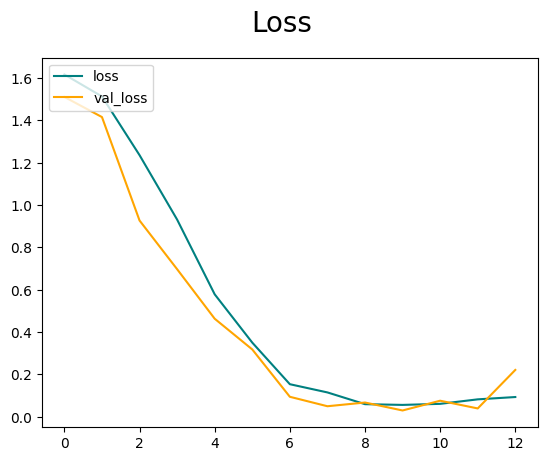

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Our model perform very well

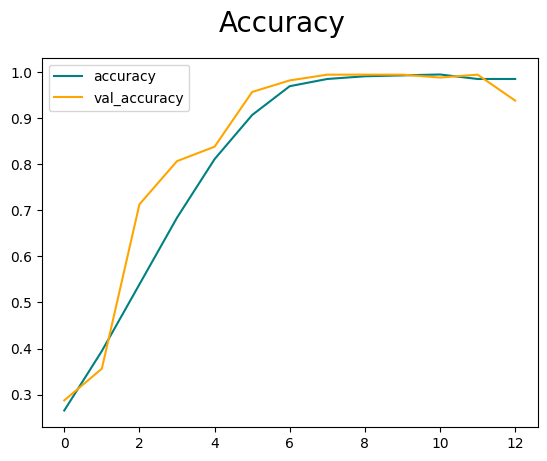

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 4.Model Evaluation

In [ ]:
from tensorflow.keras.metrics import Accuracy, Precision, Recall, BinaryAccuracy

pre = Precision()
acc = BinaryAccuracy()
rec = Recall()

In [ ]:
 len(test)

2

In [ ]:
for batch in test.as_numpy_iterator():

    X,y = batch
    pred = model.predict(X)
    pre.update_state(y,pred)
    acc.update_state(y,pred)
    rec.update_state(y,pred)

print(f'Precision : {pre.result()}, Recall : {rec.result()}, Accuracy : {acc.result()}')

1/1 [==============================] - 0s 299ms/step
Precision : 1.0, Recall : 1.0, Accuracy : 1.0


#5.Test

In [ ]:
def color_img(img):
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

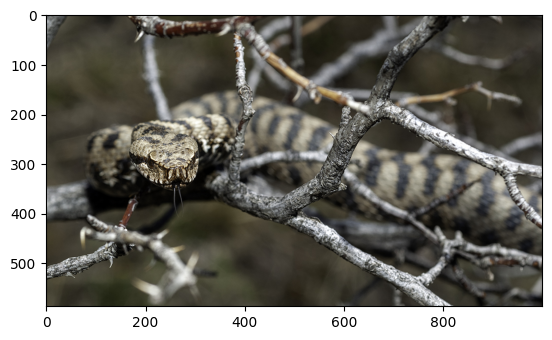

In [ ]:
vipere = color_img(cv2.imread('/content/drive/MyDrive/Project_Snake/test_vipere.jpg'))
boomslang =color_img( cv2.imread('/content/drive/MyDrive/Project_Snake/test_boomslang.jpg'))
cobra = color_img(cv2.imread('/content/drive/MyDrive/Project_Snake/test_cobra.jpg'))
taïpan = color_img(cv2.imread('/content/drive/MyDrive/Project_Snake/test_taïpan.jpg'))
crotale = color_img(cv2.imread('/content/drive/MyDrive/Project_Snake/test_crotale.jpeg'))
plt.imshow(vipere)
plt.show()

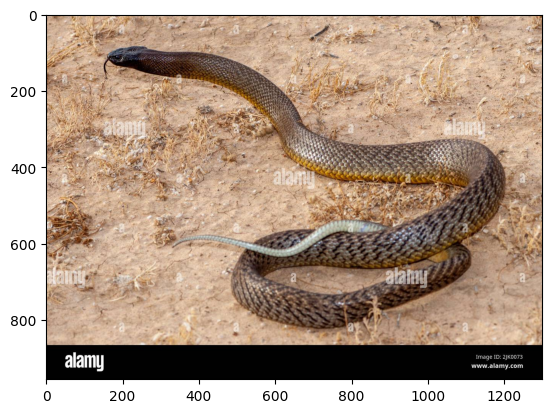

In [ ]:
plt.imshow(taïpan)

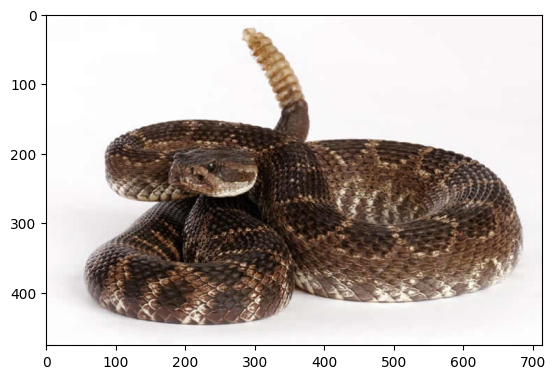

In [ ]:
plt.imshow(crotale)

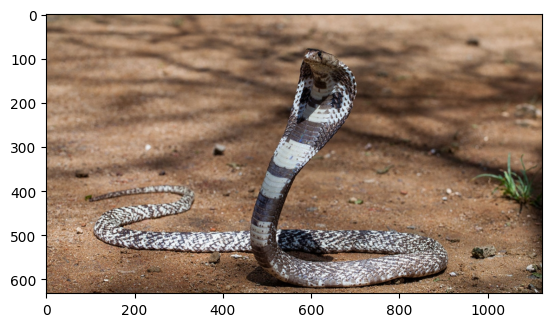

In [ ]:
plt.imshow(cobra)

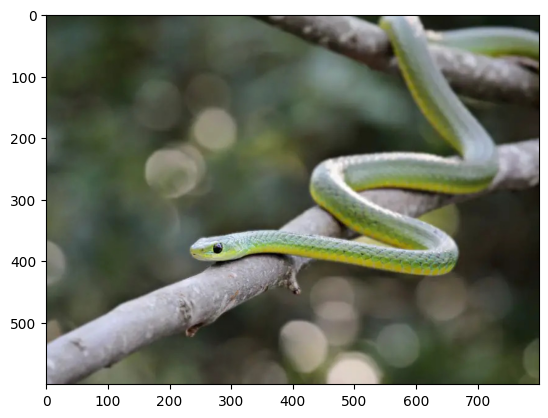

In [ ]:
plt.imshow(boomslang)

In [ ]:
resize_vipere = tf.image.resize(vipere, (256,256))
resize_boomslang = tf.image.resize(boomslang, (256,256))
resize_cobra = tf.image.resize(cobra, (256,256))
resize_taïpan = tf.image.resize(taïpan, (256,256))
resize_crotale = tf.image.resize(crotale, (256,256))

In [ ]:
boomslang_pred = model.predict(np.expand_dims(resize_boomslang/255, 0))
vipere_pred = model.predict(np.expand_dims(resize_vipere/255, 0))
cobra_pred = model.predict(np.expand_dims(resize_cobra/255, 0))
taïpan_pred = model.predict(np.expand_dims(resize_taïpan/255, 0))
crotale_pred = model.predict(np.expand_dims(resize_crotale/255, 0))

1/1 [==============================] - 0s 74ms/step


In [ ]:
print(class_names)

predicted_class_index = np.argmax(boomslang_pred)
predicted_class_name = class_names[predicted_class_index]
print(f'Predicted Class: {predicted_class_name}')


['Boomslang', 'Cobra', 'Crotale', 'Taïpan', 'Vipère']
Predicted Class: Boomslang


#6.Save model

In [ ]:
model.save(os.path.join('/content/drive/MyDrive/Project_Snake/models','snakeclassification_model.h5'))